# CNN + Data Augmentation 練習

In [1]:
# Check GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# import package
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import os

## Cifar10 資料讀入及前處理

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# image preprocessing
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255  # rescaling
x_test /= 255  # rescaling

In [5]:
# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)

y_train shape: (50000, 10)


In [0]:
## result's dictionary
model_result = dict()
model_result['acc'] = dict()
model_result['loss'] = dict()
model_result['val_acc'] = dict()
model_result['val_loss'] = dict()

## 模型定義

In [16]:
#@title 默认标题文本 { vertical-output: true }
# define model structure.
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
__________

In [0]:
# initiate optimizer
opt = keras.optimizers.adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Data Augmentation 參數設置

In [0]:
#@title Hyperparameter Setting { vertical-output: true }
data_augmentation = False #@param {type:"boolean"}
batch_size = 32 #@param {type:"integer"}
epochs = 15 #@param {type:"integer"}


In [0]:
#@title Data Augmentation Parameter Setting { vertical-output: true }
if data_augmentation:
  featurewise_center = False #@param {type:"boolean"}
  samplewise_center = False #@param {type:"boolean"}
  featurewise_std_normalization = False #@param {type:"boolean"}
  samplewise_std_normalization = False #@param {type:"boolean"}
  zca_whitening = False #@param {type:"boolean"}
  rotation_range = 0 #@param {type:"slider", min:0, max:180, step:1}
  width_shift_range = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
  height_shift_range = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
  horizontal_flip = True #@param {type:"boolean"}
  vertical_flip = False #@param {type:"boolean"}

## 開始訓練模型

In [20]:
#@title 默认标题文本 { vertical-output: true }
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=featurewise_center,  # set input mean to 0 over the dataset
        samplewise_center=samplewise_center,  # set each sample mean to 0
        featurewise_std_normalization=featurewise_std_normalization,  # divide inputs by std of the dataset
        samplewise_std_normalization=samplewise_std_normalization,  # divide each input by its std
        zca_whitening=zca_whitening,  # apply ZCA whitening
        rotation_range=rotation_range,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=width_shift_range,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=height_shift_range,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=horizontal_flip,  # randomly flip images
        vertical_flip=vertical_flip)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test))

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/15
36640/50000 [====================>.........] - ETA: 12s - loss: 1.3901 - acc: 0.5124

50000/50000 [==============================] - 50s 993us/step - loss: 1.3062 - acc: 0.5409 - val_loss: 1.0400 - val_acc: 0.6301
Epoch 2/15
23584/50000 [=============>................] - ETA: 23s - loss: 0.9517 - acc: 0.6643

50000/50000 [==============================] - 46s 928us/step - loss: 0.9136 - acc: 0.6793 - val_loss: 0.9438 - val_acc: 0.6644
Epoch 3/15
18720/50000 [==========>...................] - ETA: 27s - loss: 0.7826 - acc: 0.7221

50000/50000 [==============================] - 46s 927us/step - loss: 0.7772 - acc: 0.7263 - val_loss: 0.9020 - val_acc: 0.6771
Epoch 4/15
16864/50000 [=========>....................] - ETA: 29s - loss: 0.7056 - acc: 0.7536

50000/50000 [==============================] - 46s 929us/step - loss: 0.6990 - acc: 0.7552 - val_loss: 0.7719 - val_acc: 0.7286
Epoch 5/15
16160/50000 [========>.....................] - ETA: 29s - loss: 0.6142 - acc: 0.7837

50000/50000 [==============================] - 46s 919us/step - loss: 0.6301 - acc: 0.7801 - val_loss: 0.6144 - val_acc: 0.7857
Epoch 6/15
15904/50000 [========>.....................] - ETA: 29s - loss: 0.5691 - acc: 0.8017

50000/50000 [==============================] - 46s 922us/step - loss: 0.5723 - acc: 0.8003 - val_loss: 0.6279 - val_acc: 0.7855
Epoch 7/15
15776/50000 [========>.....................] - ETA: 30s - loss: 0.5094 - acc: 0.8221

50000/50000 [==============================] - 46s 922us/step - loss: 0.5276 - acc: 0.8148 - val_loss: 0.6200 - val_acc: 0.7921
Epoch 8/15
15776/50000 [========>.....................] - ETA: 30s - loss: 0.4700 - acc: 0.8362

50000/50000 [==============================] - 46s 921us/step - loss: 0.4864 - acc: 0.8305 - val_loss: 0.5908 - val_acc: 0.7999
Epoch 9/15
15776/50000 [========>.....................] - ETA: 29s - loss: 0.4323 - acc: 0.8507

50000/50000 [==============================] - 46s 919us/step - loss: 0.4534 - acc: 0.8426 - val_loss: 0.6728 - val_acc: 0.7765
Epoch 10/15
15712/50000 [========>.....................] - ETA: 29s - loss: 0.3953 - acc: 0.8630

50000/50000 [==============================] - 46s 920us/step - loss: 0.4173 - acc: 0.8545 - val_loss: 0.5425 - val_acc: 0.8167
Epoch 11/15
15648/50000 [========>.....................] - ETA: 30s - loss: 0.3657 - acc: 0.8725

50000/50000 [==============================] - 46s 923us/step - loss: 0.3914 - acc: 0.8621 - val_loss: 0.5569 - val_acc: 0.8140
Epoch 12/15
15648/50000 [========>.....................] - ETA: 29s - loss: 0.3472 - acc: 0.8783

50000/50000 [==============================] - 46s 916us/step - loss: 0.3645 - acc: 0.8721 - val_loss: 0.5541 - val_acc: 0.8168
Epoch 13/15
15648/50000 [========>.....................] - ETA: 29s - loss: 0.3280 - acc: 0.8832

50000/50000 [==============================] - 46s 919us/step - loss: 0.3463 - acc: 0.8770 - val_loss: 0.5352 - val_acc: 0.8201
Epoch 14/15
15616/50000 [========>.....................] - ETA: 30s - loss: 0.3138 - acc: 0.8921

50000/50000 [==============================] - 46s 920us/step - loss: 0.3244 - acc: 0.8867 - val_loss: 0.5287 - val_acc: 0.8224
Epoch 15/15
15584/50000 [========>.....................] - ETA: 29s - loss: 0.2906 - acc: 0.8998

50000/50000 [==============================] - 46s 919us/step - loss: 0.3056 - acc: 0.8918 - val_loss: 0.5367 - val_acc: 0.8247


## 訓練結果視覺化

In [0]:
#@title Save Learning Result { vertical-output: true }
experiment = "no data augmentation" #@param {type:"string"}

model_result['acc'][experiment] = model.model.history.history.get('acc')
model_result['val_acc'][experiment] = model.model.history.history.get('val_acc')
model_result['loss'][experiment] = model.model.history.history.get('loss')
model_result['val_loss'][experiment] = model.model.history.history.get('val_loss')

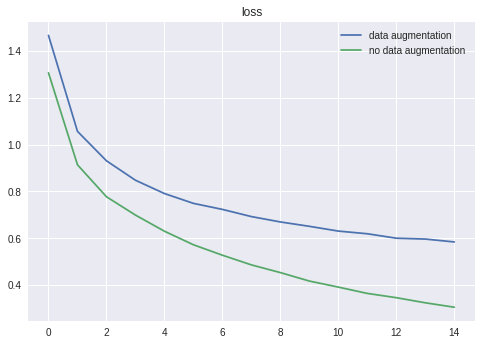

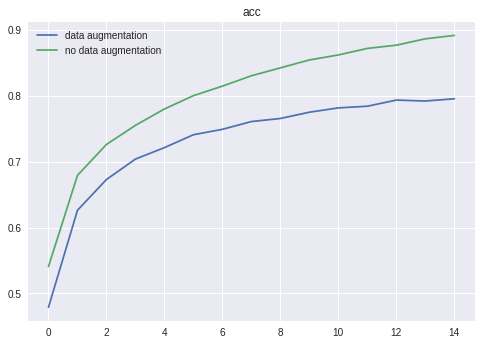

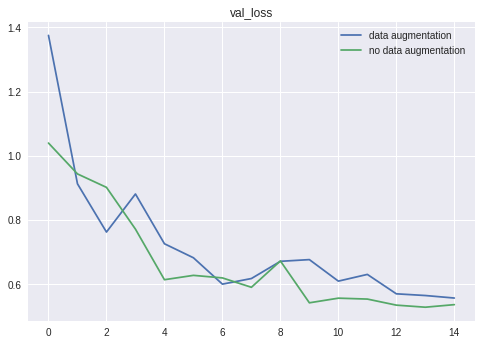

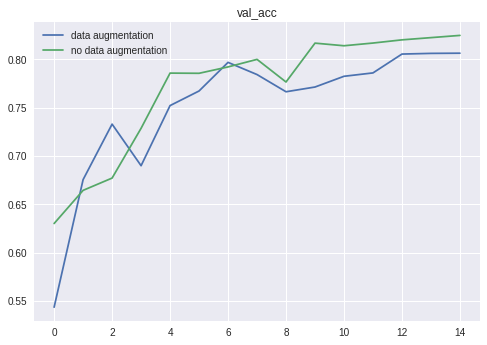

In [22]:
#@title Model Result { vertical-output: true }
import matplotlib.pyplot as plt

# training loss
for i in model_result['loss'].keys():
  plt.plot(np.arange(len(model_result['loss'][i])), model_result['loss'][i], label = i)

plt.legend(loc='best')
plt.title('loss')
plt.show()

# training acc
for i in model_result['acc'].keys():
  plt.plot(np.arange(len(model_result['acc'][i])), model_result['acc'][i], label = i)

plt.legend(loc='best')
plt.title('acc')
plt.show()

# valid loss
for i in model_result['val_loss'].keys():
  plt.plot(np.arange(len(model_result['val_loss'][i])), model_result['val_loss'][i], label = i)

plt.legend(loc='best')
plt.title('val_loss')
plt.show()


# valid acc
for i in model_result['val_acc'].keys():
  plt.plot(np.arange(len(model_result['val_acc'][i])), model_result['val_acc'][i], label = i)

plt.legend(loc='best')
plt.title('val_acc')
plt.show()